# PPO, R-PPO and VAE comparison

## Frauds in the dataset
We compute how much money a fraudster is able to collect with a card in the simulator.

In [ ]:
from parameters import CardSimParameters

p = CardSimParameters.paper_params()
fraudulent_cards, terminals, transactions = p.get_simulation_data()

Sourcing DCPC data


INFO:cardsim.cardsim.Cardsim:Sourcing DCPC data


Sourcing successful; formatting data


INFO:cardsim.cardsim.Cardsim:Sourcing successful; formatting data


DCPC data sourcing and formatting complete


INFO:cardsim.cardsim.Cardsim:DCPC data sourcing and formatting complete


Generating payer profiles for 20000 payers


INFO:cardsim.cardsim.Cardsim:Generating payer profiles for 20000 payers


Generating payee profiles for 2000 payees


INFO:cardsim.cardsim.Cardsim:Generating payee profiles for 2000 payees


In [ ]:
from parameters import CardSimParameters, Parameters

params = Parameters(cardsim=CardSimParameters.paper_params())
env = params.create_env()
banksys = env.system

In [ ]:
frauds = [t for t in transactions if t.]
frauds.sort(key=lambda t: t.timestamp)
print(len(frauds))
n_cards = set(t.card_id for t in frauds)
print(len(n_cards))

In [ ]:
import matplotlib.pyplot as plt

amounts = [t.amount for t in transactions]
plt.boxplot(amounts, vert=False)

In [ ]:
plt.boxplot(amounts, vert=True, showfliers=False)


In [6]:
from tqdm import tqdm

blocked_cards = set()
frauds_amounts = list[float]()

for trx in tqdm(frauds):
    if trx.card_id in blocked_cards:
        continue
    if banksys.process_transaction(trx):
        blocked_cards.add(trx.card_id)
        frauds_amounts.append(0.0)
    else:
        undetected_frauds.append(trx)

100%|██████████| 158171/158171 [03:48<00:00, 693.17it/s]  


## Score over training time

In [1]:
import numpy as np

anomaly = True

if anomaly:
    logdirs = {
        "VAE": "../logs/anomaly/vae/2025-09-19T15-46-05.846486",
        "PPO": "../logs/anomaly/ppo/2025-09-19T09-43-04.501028",
        "R-PPO": "../logs/anomaly/rppo/2025-09-19T13-05-17.374379",
    }
else:
    logdirs = {
        "VAE": "logs/no-anomaly/no-anomaly/vae/2025-09-19T16-41-07.764246",
        "PPO": "logs/no-anomaly/no-anomaly/ppo/2025-09-19T11-40-32.971413",
        "R-PPO": "logs/no-anomaly/no-anomaly/rppo/2025-09-19T14-08-14.120200"
    }

    
def moving_average(data, window_size=100):
    """Compute the moving average of a 1D array."""
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


logs/exp-final/vae
There are 4 runs in VAE
logs/exp-final/ppo
There are 4 runs in PPO
logs/exp-final/rppo
There are 4 runs in R-PPO


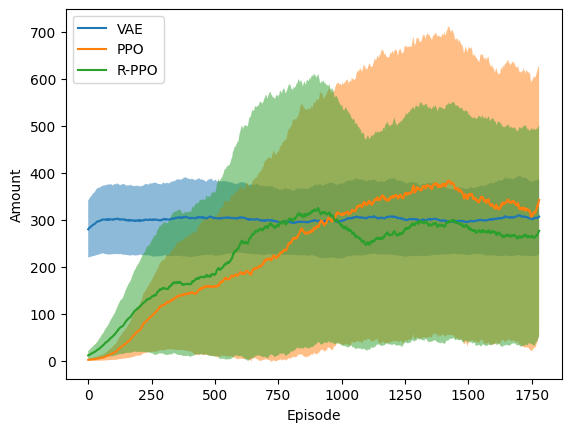

In [ ]:
import matplotlib.pyplot as plt
from plots import Experiment

PLOT_SUM = False
import numpy as np
import matplotlib.pyplot as plt

# First, collect all sequences to determine the max length
all_means = {}
all_stds = {}
max_len = 2500

# First pass to find max length
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    mean, std = exp.mean_std_amounts_over_time
    mean = moving_average(mean)
    summa = np.cumsum(mean)
    std = moving_average(std)
    all_means[label] = mean
    all_sums[label] = summa
    all_stds[label] = std
    max_len = max(max_len, len(mean))

# Now pad all sequences to max_len with NaNs
for label in logdirs:
    mean = all_means[label]
    summa = all_sums[label]
    std = all_stds[label]
    padded_mean = np.full(max_len, np.nan)
    padded_sum = np.full(max_len, np.nan)
    padded_std = np.full(max_len, np.nan)
    padded_mean[:len(mean)] = mean
    padded_sum[:len(summa)] = summa
    padded_std[:len(std)] = std


    # Compute 95% CI
    # ci95 = 1.96 * (padded_std / exp.n_runs**0.5)
    x = np.arange(max_len)
    if PLOT_SUM:
        plt.plot(x, padded_sum, label=label)
    else:
        plt.plot(x, padded_mean, label=label)
    #plt.fill_between(x, padded_mean - ci95, padded_mean + ci95, alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Amount")
#plt.ylim(top=300)
plt.legend()
plt.savefig("amount-over-time_anomaly.svg")



In [ ]:
import numpy as np
import pandas as pd

# Dictionary to store results
results = {
    "Label": [],
    "Episodes": [],
    "Mean": [],
    #"Variance": []
}

for label, logdir in logdirs.items():
    print(logdir)
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    amounts = exp.amounts_over_time  # shape: (n_runs, n_episodes)

    for episodes in [1000, 2000, 4000]:
        if amounts.shape[1] >= episodes:
            cumulated = np.sum(amounts[:, :episodes], axis=1)
            mean = int(np.mean(cumulated))
            var = np.round(np.var(cumulated, ddof=1), 2)  # sample variance

            results["Label"].append(label)
            results["Episodes"].append(episodes)
            results["Mean"].append(mean)
            #results["Variance"].append(var)
        else:
            print(f"{label} has fewer than {episodes} episodes. Skipping.")

        

# Convert to DataFrame for pretty printing or export
results_df = pd.DataFrame(results)
results_df


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary to store results
results = {
    "Label": [],
    "Episodes": [],
    "Mean": [],
    #"Variance": []
}

# Long-form storage for boxplots
all_values = {
    "Label": [],
    "Episodes": [],
    "Value": []
}

for label, logdir in logdirs.items():
    print(logdir)
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    amounts = exp.amounts_over_time  # shape: (n_runs, n_episodes)

    for episodes in [1000, 2000, 4000]:
        if amounts.shape[1] >= episodes:
            cumulated = np.sum(amounts[:, :episodes], axis=1)
            mean = int(np.mean(cumulated))
            var = np.round(np.var(cumulated, ddof=1), 2)  # sample variance

            # Store summary stats
            results["Label"].append(label)
            results["Episodes"].append(episodes)
            results["Mean"].append(mean)
            #results["Variance"].append(var)

            # Store all values for plotting
            all_values["Label"].extend([label] * len(cumulated))
            all_values["Episodes"].extend([episodes] * len(cumulated))
            all_values["Value"].extend(cumulated.tolist())
        else:
            print(f"{label} has fewer than {episodes} episodes. Skipping.")

# Convert to DataFrames
results_df = pd.DataFrame(results)
all_values_df = pd.DataFrame(all_values)

print(results_df)

# --- Plot boxplots ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_values_df, x="Episodes", y="Value", hue="Label", showmeans=True, 
            showfliers=True, meanprops={"markerfacecolor": "red", "markeredgecolor": "red"},)
plt.title("Distribution of Cumulative Rewards by Episodes and Label")
plt.ylabel("Cumulative Reward")
plt.xlabel("Episodes")
plt.legend(title="Label")
plt.show()


../logs/anomaly/vae/2025-09-19T15-46-05.846486


NameError: name 'Experiment' is not defined

In [ ]:

table_df = pd.DataFrame()

for length in (1000, 2000, 4000):
    for label in ['VAE', 'PPO', 'R-PPO']:
        # Select the row in results_df where Episodes == length and Label == label
        value = results_df.loc[
            (results_df['Episodes'] == length) & (results_df['Label'] == label),
            'Mean'
        ].values[0]  # take the scalar

        # Assign it to your new table_df
        table_df.loc[label, length] = value
table_df

## Number of transactions per card over time

import matplotlib.pyplot as plt
from plots import Experiment


for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    print(f"There are {exp.n_runs} runs in {label}")
    data = exp.n_transactions_over_time
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    mean = moving_average(mean, window_size=100)[:-20]
    std = moving_average(std, window_size=100)[:-20]
    # Compute the 95% confidence interval from the STD
    ci95 = 1.96 * (std / exp.n_runs**0.5)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.5)

plt.xlabel("Episode")
plt.ylabel("Number of transactions per card")
plt.legend()
plt.savefig("n-transactions.svg")

experiment = Experiment.load(logdir)
label, max(experiment.n_transactions_over_time[0])

In [ ]:
exp.total_amounts

## Total amount collected

C:\Users\dalun\AppData\Local\Temp\ipykernel_31380\2554115465.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(amounts, labels=labels, showmeans=True)


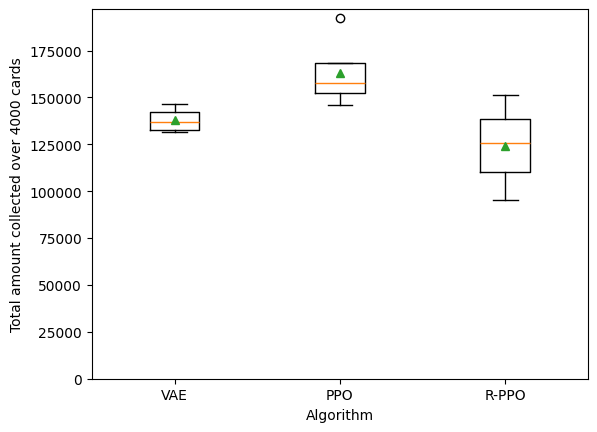

In [10]:
import matplotlib.pyplot as plt
from plots import Experiment

amounts = []
labels = []
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    amounts.append(exp.total_amounts)
    labels.append(label)

plt.boxplot(amounts, labels=labels, showmeans=True)
plt.ylabel("Total amount collected over 4000 cards")
plt.xlabel("Algorithm")
#plt.grid(axis="y")
plt.ylim(bottom=0)  #0  1_000_000
plt.savefig("boxplot-amounts_Anomaly.svg")
plt.show()


###### Plot amounts boxplots


import matplotlib.pyplot as plt
from plots import Experiment

amounts = []
labels = []
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    amounts.append(exp.amounts_over_time)
    print(amounts)
    labels.append(label)

plt.boxplot(amounts, labels=labels, showmeans=True)
plt.ylabel("Total amount collected over 4000 cards")
plt.xlabel("Algorithm")
#plt.ylim(bottom=0)  # Set lower y-axis limit to 0
plt.savefig("boxplot-amounts.svg")
plt.show()


In [ ]:
exp.get_actions()

In [ ]:
exp.amounts_over_time[0]